# Time tracked trajectories, parametrised by number of e-folds

In [2]:
import numpy as np
import matplotlib.pyplot as py

In [3]:
grad_calc = lambda H, V0, phi, k: (1.5*(H**2) - 0.5*V0*(phi**k))**0.5
epsilon_calc = lambda  H, V0, phi, k: 2*(1.5*(H**2) - 0.5*V0*(phi**k))/(H**2)

Below I have included updated `trajectory` and `tot_traj` functions - they include parameter check suppression options(`suppress`), but more importantly and `epsilonstop` option which runs the $H$ trajectory from the end of inflation back to $\varepsilon = 1$, which is inflation as per its definition in the formal model, rather than ending inflation after a predecided number of e-folds.

In [ ]:
def trajectory(V_0, k, phi_0, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False):
    if not (3*(H0**2)/((phi_0)**k) > V_0 > 2*(H0**2)/((phi_0)**k) or suppress):
        raise Exception("wrong parameter choice")
    T =  int(phi_0/dphi0)
    phi = np.zeros(boundmultiplier*T+1)  #adapting mesh for phi
    H = np.zeros(boundmultiplier*T+1)
    phi[0] = phi_0
    H[0]  = H0
    epsilon = epsilon_calc(H[0], V_0, phi[0], k)
    n = 0
    dphi = dphi0
    #SPACE
    while (epsilon < 1) and (n < boundmultiplier*T):
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] - 0.5*dphi*K1, V_0, phi[n] - 0.5*dphi, k)
        K3 = grad_calc(H[n] - 0.5*dphi*K2, V_0, phi[n] - 0.5*dphi, k)
        K4 = grad_calc(H[n] - dphi*K3, V_0, phi[n] - dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] - dphi
        epsilon = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        dphi = min(0.9*(H[n+1] - ((V_0*(phi[n+1])**k)*(1/3))**0.5)/(grad_calc(H[n+1], V_0, phi[n+1], k)), dphi0)
        n += 1
    return phi[0:n+1], H[0:n+1], n, epsilon

def tot_traj(Nstart, V_0, k, phi_0 = 10, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2.5, suppress = False, epsilonstop = False):
    T = int(phi_0/dphi0)
    phiswap, Jswap, n0, epsilon = trajectory(V_0, k, phi_0, dphi0, boundmultiplier, H0, suppress)
    phi1, J1 = phiswap[::-1], Jswap[::-1]
    N = np.zeros(boundmultiplier*T + 1)
    phi = np.zeros(boundmultiplier*T + 1)
    H = np.zeros(boundmultiplier*T + 1)
    ε = np.zeros(boundmultiplier*T + 1)
    phi[:n0 + 1] = phi1
    H[:n0 + 1] = J1
    ε[0] = epsilon
    n = 0
    while (N[n] < Nstart) and (n < n0):
        dphi = phi[n+1] - phi[n]
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(J1 + J2)/4
        n += 1
    #Space
    while (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        dphi = min(0.5*(H[n] - ((V_0*(phi[n])**k)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], k)), dphi0)
        K1 = grad_calc(H[n], V_0, phi[n], k)
        K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, k)
        K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, k)
        K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, k)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] + dphi*grad
        phi[n+1] = phi[n] + dphi
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], k)
        #SPACE
        J1 = (2 / ε[n])**0.5
        J2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(J1 + J2)/4
        n += 1
    return phi[:n+1], H[:n+1], n, ε[:n+1], N[:n+1]

In [ ]:
axes.labelsize : 20
lines.markersize : 10

n = 142065
N = [0.00000000e+00 7.07109709e-05 1.41425953e-04 ... 5.47389474e+01
 5.47390181e+01 5.47390888e+01]
Full trajectory not available via this method - ε > 1 at n = 142065


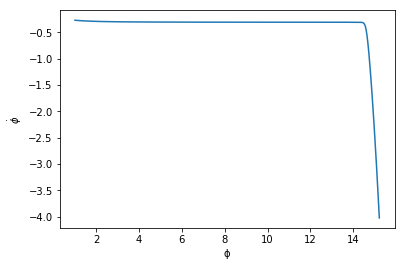

<Figure size 720x720 with 0 Axes>

In [11]:
kchoice = 2
V0choice = 0.07

phi, H, n, epsilon, N = tot_traj(60, V0choice, kchoice, phi_0 = 15, suppress = False, epsilonstop = True)
Vset = [V0choice*ϕ**kchoice for ϕ in phi]
phidot = [-(6*((H[i])**2) - 2*(Vset[i]))**0.5 for i in range(len(phi))]
py.plot(phi, phidot)
py.xlabel('ϕ')
py.ylabel('$\dot{\phi}$')
py.figure(figsize =(10, 10))


print("n =", n, end = '\n')
print("N =", N, end = '\n')
for i, el in enumerate(epsilon):
    if el >1 and i>0:
        print("Full trajectory not available via this method - ε > 1 at n = %s"%i)
        break

## $N$ parametrised trajectories of $\phi$, $\dot{\phi}$ and $H$

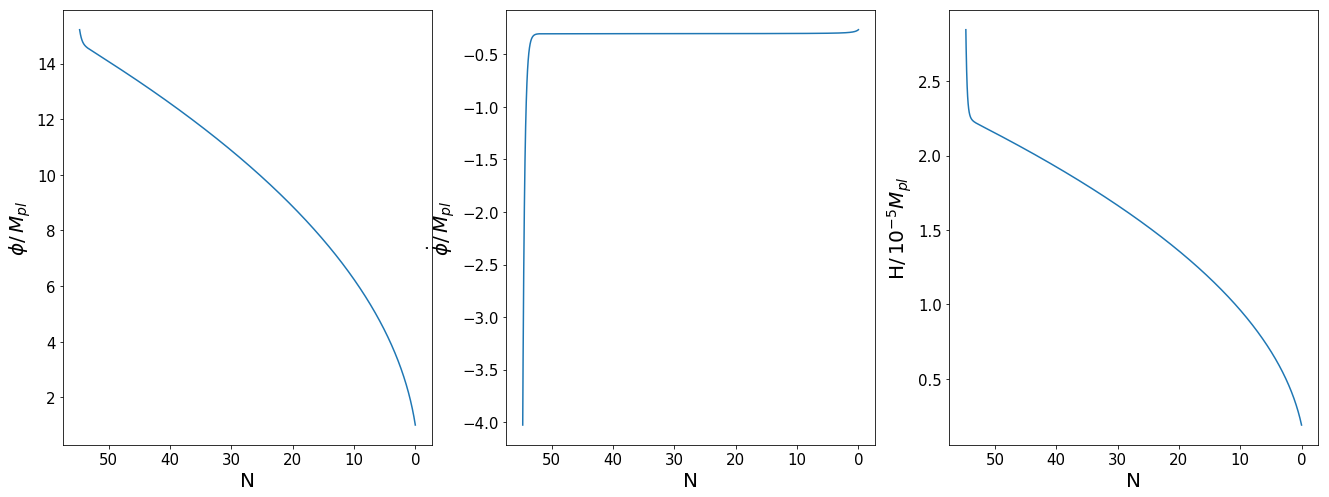

In [27]:
py.style.use('subplotlabels.txt')

Ntraj, Nax = py.subplots(1,3, figsize = (22.5, 8))
Nax[0].plot(N, phi)
Nax[0].set(xlabel ='N', ylabel = '$\phi/\, M_{pl}$')
Nax[0].invert_xaxis()

Nax[1].plot(N, phidot)
Nax[1].set(xlabel = 'N', ylabel = '$\dot{\phi}/\, M_{pl}$')
Nax[1].invert_xaxis()

Nax[2].plot(N, H)
Nax[2].set(xlabel = 'N', ylabel = 'H/$\, 10^{-5}M_{pl}$')
Nax[2].invert_xaxis()

In the future, though we will struggle to choose initial $\phi$ coinciding with $\phi_{\mathrm{start}}$, by setting `epsilonstop=True` we may choose initial $\phi$ lose to the $\varepsilon = 1$ subspace to ensure that the starting $H$ value is sensible (and we should automate this)

In [ ]:
https://stackoverflow.com/a/14971193